In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import remove_nan
from statsmodels.multivariate.pca import PCA
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
full = pd.read_csv('normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [3]:
sliced = full.loc["1960-01-01":"2019-01-01"]
sliced.shape

(709, 31)

In [4]:
sliced = remove_nan(sliced)
print(sliced.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [33]:
length = sliced.shape[0]
test_start = round(length * 0.9)
print(test_start)

638


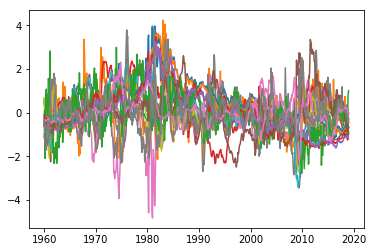

In [6]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

core = sliced[core_series]
other = sliced.drop(columns=core_series)

plt.plot(other)

0     4.788230e+03
1     2.420504e+03
2     1.805296e+03
3     8.092765e+02
4     6.652454e+02
5     5.433721e+02
6     4.330693e+02
7     3.761847e+02
8     2.948238e+02
9     2.842098e+02
10    1.627130e+02
11    8.476064e+01
12    5.297524e+01
13    2.374648e+01
14    1.326844e+01
15    2.692640e+00
16    1.632064e+00
17    2.079054e-29
Name: eigenvals, dtype: float64

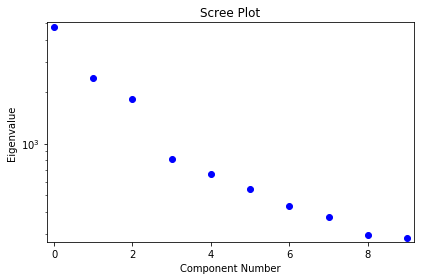

In [10]:
# already demeaned/standardised
pc = PCA(other, standardize=False, demean=False, normalize=False, method='svd')
pc.plot_scree()
pc.eigenvals

In [18]:
print(pc.factors["comp_00"].shape)

var_series = pd.concat([core, pc.factors[["comp_00", "comp_01"]]], axis=1)
var_series.shape

(709,)


(709, 5)

In [22]:
train = var_series.iloc[:test_start-1]
test = var_series.iloc[test_start:]

print(train.shape)

(637, 5)


In [23]:
model = VAR(train, freq='MS')
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,-16.43,-16.40,7.312e-08,-16.42
1,-33.99,-33.77,1.734e-15,-33.91
2,-35.10,-34.71*,5.712e-16,-34.95*
3,-35.14,-34.57,5.481e-16,-34.92
4,-35.16,-34.42,5.349e-16,-34.87
5,-35.24,-34.32,4.938e-16,-34.88
6,-35.21,-34.10,5.138e-16,-34.78
7,-35.17,-33.89,5.317e-16,-34.67
8,-35.17,-33.71,5.340e-16,-34.60
9,-35.17,-33.53,5.343e-16,-34.53


In [24]:
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Aug, 2019
Time:                     17:58:32
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -33.3846
Nobs:                     623.000    HQIC:                  -34.9295
Log likelihood:           7121.43    FPE:                2.54682e-16
AIC:                     -35.9115    Det(Omega_mle):     1.48471e-16
--------------------------------------------------------------------
Results for equation CPIAUCSL
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.004045         0.004269            0.948           0.343
L1.CPIAUCSL                 1.326166         0.043697           30.349           0.000
L1.A191RO1Q156NBEA         -0.038

In [25]:
from utils import plot_var_forc

In [26]:
def plot_forecast_custom(results, steps, previous = 20, alpha=0.05, plot_stderr=True):
    mid, lower, upper = results.forecast_interval(results.y, steps=12, alpha=0.05)
    fig = plot_var_forc(results.y[-previous:], mid, lower, upper, names=results.names, plot_stderr=plot_stderr)
    return fig


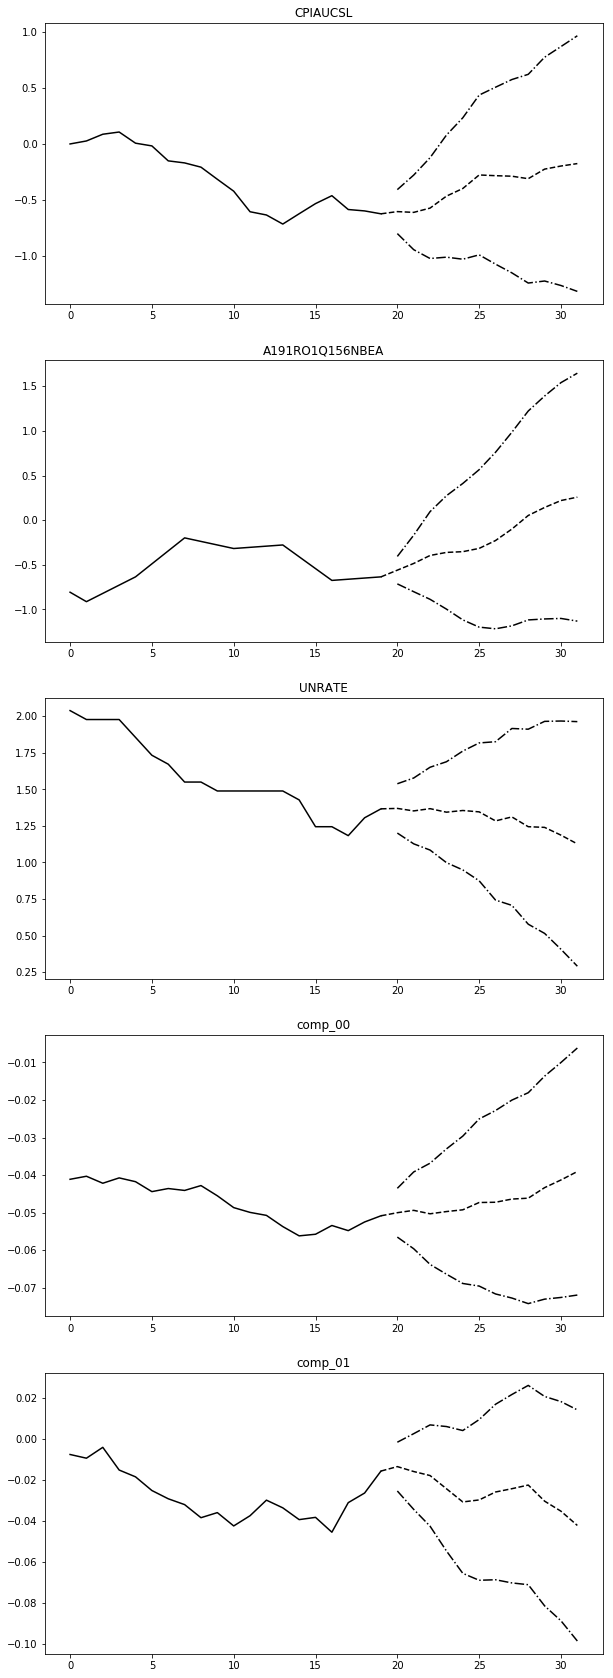

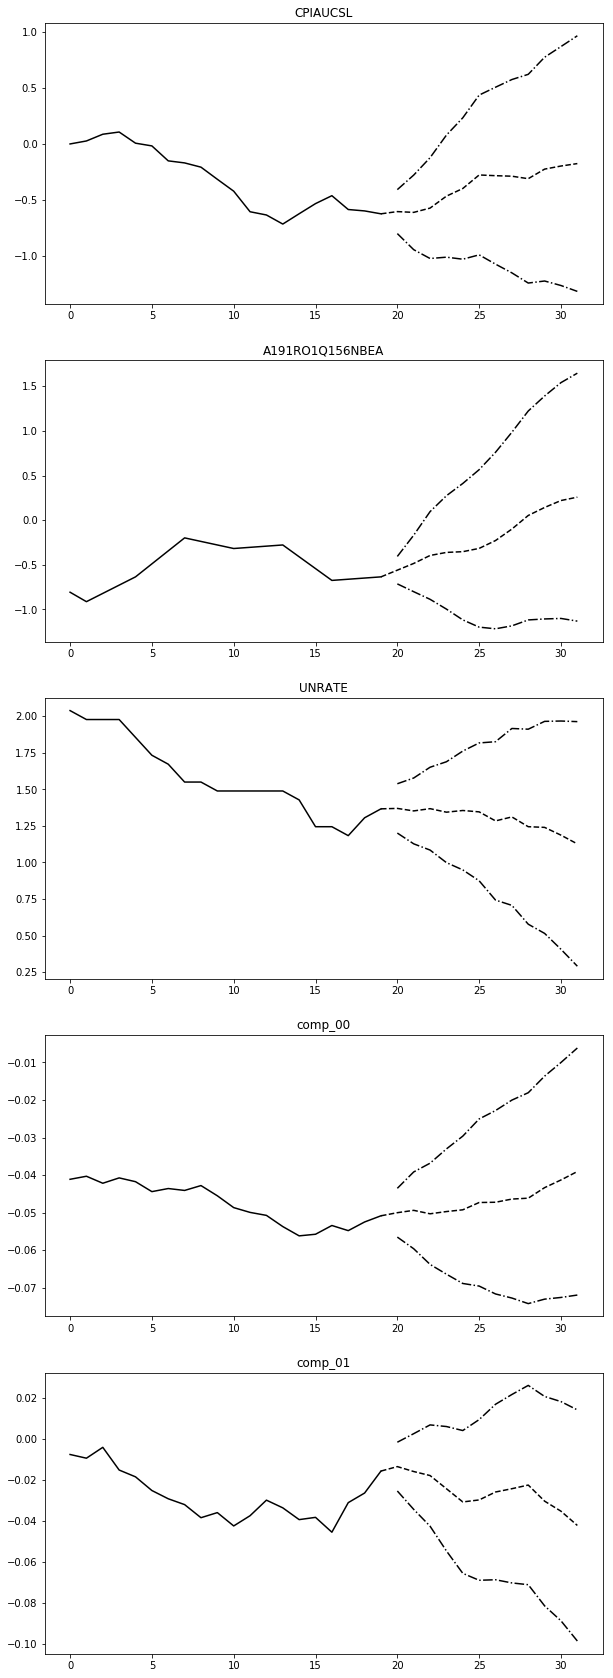

In [27]:
plot_forecast_custom(results, steps = 12)

In [38]:
lag_order = results.k_ar
forecasts = np.empty((len(test) - lag_order, 3))

for i in range(len(test) - lag_order):
    forecast = results.forecast(test.values[i:lag_order + i], steps=1)
    forecasts[i] = forecast.squeeze()[:3]

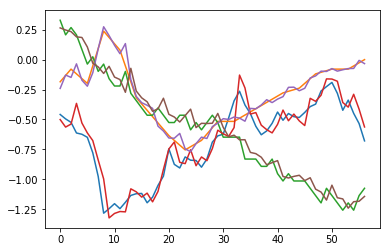

In [40]:
plt.plot(test.values[lag_order:, :3])
plt.plot(forecasts)

In [41]:
from sklearn.metrics import mean_squared_error

In [44]:
mse = mean_squared_error(forecasts, test.values[lag_order:, :3])
print("Average MSE on test set: " + str(mse))

Average MSE on test set: 0.0058903869079888135


In [ ]:
# Now results with three factors: